In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, classification_report,
                           roc_auc_score, roc_curve, precision_recall_curve)
from scipy.stats import pearsonr
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
import pickle
import warnings
warnings.filterwarnings('ignore')

In [8]:
df=pd.read_csv('/content/personality_dataset.csv')
df.head()


,Personality
0,Extrovert
1,Introvert
2,Introvert
3,Extrovert
4,Extrovert
...,...
2895,Extrovert
2896,Extrovert
2897,Introvert
2898,Introvert


In [17]:
df.isnull().sum()

,0
Time_spent_Alone,63
Stage_fear,73
Social_event_attendance,62
Going_outside,66
Drained_after_socializing,52
Friends_circle_size,77
Post_frequency,65
Personality,0


In [9]:
df.columns

Index(['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
       'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
       'Post_frequency', 'Personality'],
      dtype='object')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2837 non-null   float64
 1   Stage_fear                 2827 non-null   object 
 2   Social_event_attendance    2838 non-null   float64
 3   Going_outside              2834 non-null   float64
 4   Drained_after_socializing  2848 non-null   object 
 5   Friends_circle_size        2823 non-null   float64
 6   Post_frequency             2835 non-null   float64
 7   Personality                2900 non-null   object 
dtypes: float64(5), object(3)
memory usage: 181.4+ KB


In [30]:
# prompt: use label encoder for col Stage_fear and  Drained_after_socializing

le = LabelEncoder()
df['Stage_fear'] = le.fit_transform(df['Stage_fear'])
df['Drained_after_socializing'] = le.fit_transform(df['Drained_after_socializing'])
df.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,0,4.0,6.0,0,13.0,5.0,Extrovert
1,9.0,1,0.0,0.0,1,0.0,3.0,Introvert
2,9.0,1,1.0,2.0,1,5.0,2.0,Introvert
3,0.0,0,6.0,7.0,0,14.0,8.0,Extrovert
4,3.0,0,9.0,4.0,0,8.0,5.0,Extrovert


In [18]:
# prompt: fill null missing value columns having float and int by its mean and categorical column by it mode

for column in df.columns:
  if df[column].isnull().any():
    if df[column].dtype in ['float64', 'int64']:
      df[column].fillna(df[column].mean(), inplace=True)
    elif df[column].dtype == 'object':
      df[column].fillna(df[column].mode()[0], inplace=True)
df.isnull().sum()


,0
Time_spent_Alone,0
Stage_fear,0
Social_event_attendance,0
Going_outside,0
Drained_after_socializing,0
Friends_circle_size,0
Post_frequency,0
Personality,0


In [33]:
x=df.drop('Personality',axis=1)
y=df['Personality']

In [34]:
x.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,4.0,0,4.0,6.0,0,13.0,5.0
1,9.0,1,0.0,0.0,1,0.0,3.0
2,9.0,1,1.0,2.0,1,5.0,2.0
3,0.0,0,6.0,7.0,0,14.0,8.0
4,3.0,0,9.0,4.0,0,8.0,5.0


# Classification EDA Implementation

In [2]:
class ClassificationEDAAnalyzer:
    def __init__(self, df, target_col):
        self.df = df
        self.target_col = target_col
        self.eda_results = {}

    def basic_info(self):
        """Basic dataset information for classification"""
        info = {
            'shape': self.df.shape,
            'columns': list(self.df.columns),
            'dtypes': self.df.dtypes.to_dict(),
            'missing_values': self.df.isnull().sum().to_dict(),
            'duplicates': self.df.duplicated().sum(),
            'target_distribution': self.df[self.target_col].value_counts().to_dict(),
            'class_balance': (self.df[self.target_col].value_counts() / len(self.df)).to_dict()
        }
        self.eda_results['basic_info'] = info
        return info

    def target_distribution_plot(self):
        """Visualize target variable distribution"""
        plt.figure(figsize=(12, 5))

        # Count plot
        plt.subplot(1, 2, 1)
        self.df[self.target_col].value_counts().plot(kind='bar')
        plt.title('Target Variable Distribution')
        plt.xlabel(self.target_col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)

        # Pie chart
        plt.subplot(1, 2, 2)
        self.df[self.target_col].value_counts().plot(kind='pie', autopct='%1.1f%%')
        plt.title('Target Variable Percentage')
        plt.ylabel('')

        plt.tight_layout()
        plt.savefig('target_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Check for class imbalance
        class_counts = self.df[self.target_col].value_counts()
        imbalance_ratio = class_counts.max() / class_counts.min()
        print(f"Class Imbalance Ratio: {imbalance_ratio:.2f}")
        if imbalance_ratio > 2:
            print("⚠️ Dataset appears to be imbalanced. Consider using SMOTE or class weights.")

    def correlation_analysis(self):
        """Generate correlation matrix and heatmap"""
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        corr_matrix = self.df[numeric_cols].corr()

        # Create correlation heatmap
        plt.figure(figsize=(12, 8))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                   square=True, linewidths=.5, cbar_kws={"shrink": .5})
        plt.title('Feature Correlation Matrix')
        plt.tight_layout()
        plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()

        self.eda_results['correlation_matrix'] = corr_matrix.to_dict()
        return corr_matrix

    def feature_target_analysis(self, features=None):
        """Analyze relationship between features and target"""
        if features is None:
            numeric_cols = self.df.select_dtypes(include=[np.number]).columns
            features = [col for col in numeric_cols if col != self.target_col][:6]

        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.ravel()

        for i, feature in enumerate(features):
            if i < 6:
                # Box plot for numeric features vs target
                if self.df[feature].dtype in ['int64', 'float64']:
                    self.df.boxplot(column=feature, by=self.target_col, ax=axes[i])
                    axes[i].set_title(f'{feature} by {self.target_col}')
                    axes[i].set_xlabel(self.target_col)
                else:
                    # Bar plot for categorical features
                    pd.crosstab(self.df[feature], self.df[self.target_col]).plot(kind='bar', ax=axes[i])
                    axes[i].set_title(f'{feature} vs {self.target_col}')
                    axes[i].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.savefig('feature_target_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

    def vif_analysis(self):
        """Calculate Variance Inflation Factor"""
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        numeric_cols = [col for col in numeric_cols if col != self.target_col]

        if len(numeric_cols) > 1:
            vif_data = pd.DataFrame()
            vif_data["Feature"] = numeric_cols
            vif_data["VIF"] = [variance_inflation_factor(self.df[numeric_cols].values, i)
                              for i in range(len(numeric_cols))]

            # Color code VIF values
            def vif_interpretation(vif):
                if vif < 5:
                    return "Low"
                elif vif < 10:
                    return "Moderate"
                else:
                    return "High"

            vif_data["Multicollinearity"] = vif_data["VIF"].apply(vif_interpretation)

            self.eda_results['vif_analysis'] = vif_data.to_dict('records')
            return vif_data
        else:
            print("Not enough numeric features for VIF analysis")
            return None

    def categorical_analysis(self):
        """Analyze categorical features"""
        categorical_cols = self.df.select_dtypes(include=['object']).columns
        categorical_cols = [col for col in categorical_cols if col != self.target_col]

        if len(categorical_cols) > 0:
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))
            axes = axes.ravel()

            for i, col in enumerate(categorical_cols[:4]):
                if i < 4:
                    # Stacked bar chart
                    pd.crosstab(self.df[col], self.df[self.target_col], normalize='index').plot(
                        kind='bar', stacked=True, ax=axes[i]
                    )
                    axes[i].set_title(f'{col} vs {self.target_col} (Normalized)')
                    axes[i].tick_params(axis='x', rotation=45)
                    axes[i].legend(title=self.target_col)

            plt.tight_layout()
            plt.savefig('categorical_analysis.png', dpi=300, bbox_inches='tight')
            plt.show()

Basic Info: {'shape': (2900, 8), 'columns': ['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance', 'Going_outside', 'Drained_after_socializing', 'Friends_circle_size', 'Post_frequency', 'Personality'], 'dtypes': {'Time_spent_Alone': dtype('float64'), 'Stage_fear': dtype('O'), 'Social_event_attendance': dtype('float64'), 'Going_outside': dtype('float64'), 'Drained_after_socializing': dtype('O'), 'Friends_circle_size': dtype('float64'), 'Post_frequency': dtype('float64'), 'Personality': dtype('O')}, 'missing_values': {'Time_spent_Alone': 0, 'Stage_fear': 0, 'Social_event_attendance': 0, 'Going_outside': 0, 'Drained_after_socializing': 0, 'Friends_circle_size': 0, 'Post_frequency': 0, 'Personality': 0}, 'duplicates': np.int64(402), 'target_distribution': {'Extrovert': 1491, 'Introvert': 1409}, 'class_balance': {'Extrovert': 0.5141379310344828, 'Introvert': 0.48586206896551726}}


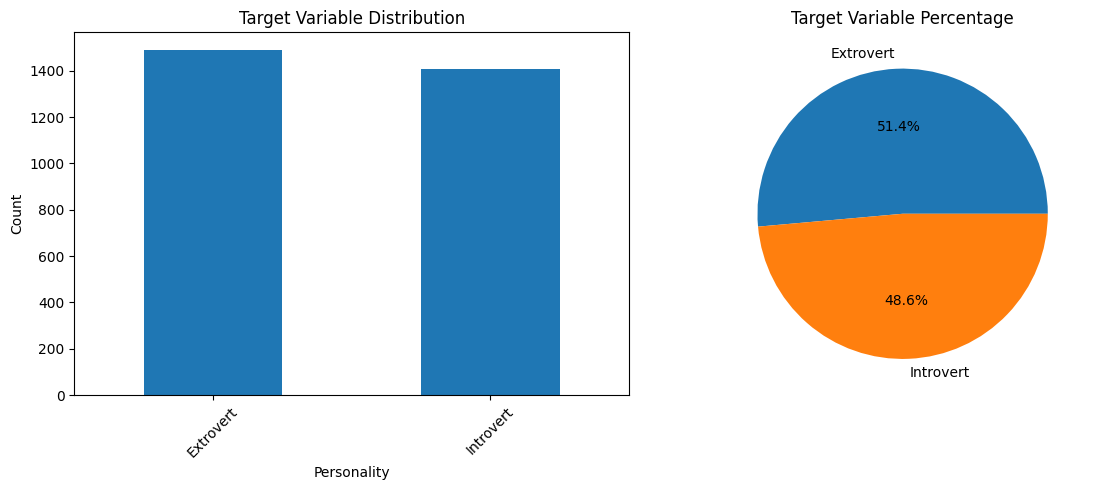

Class Imbalance Ratio: 1.06


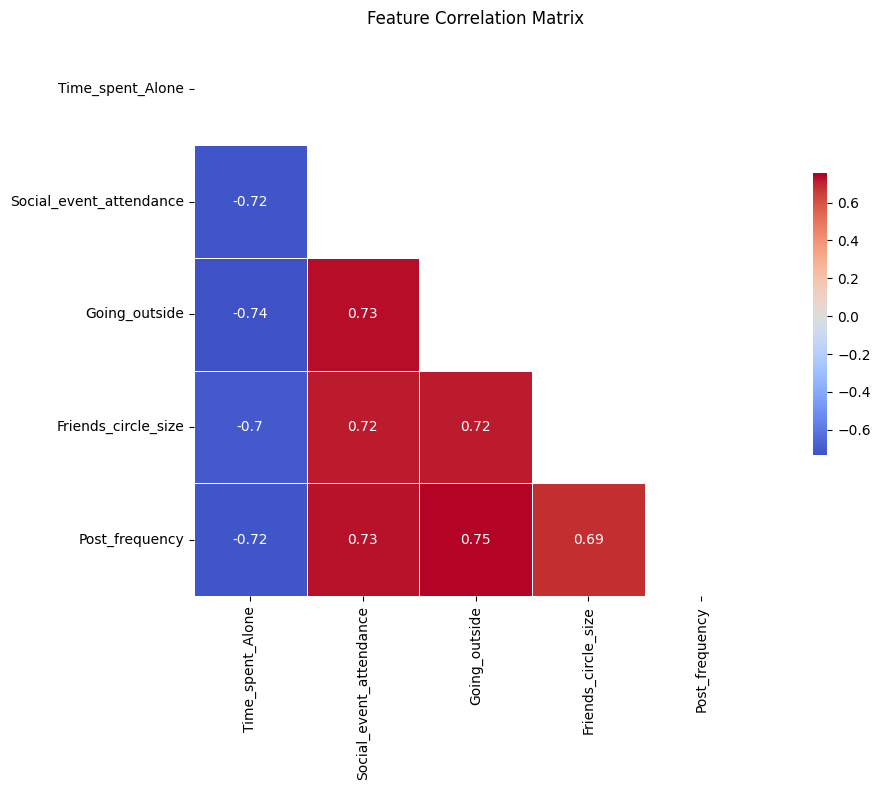

Correlation Matrix:                          Time_spent_Alone  Social_event_attendance  \
Time_spent_Alone                 1.000000                -0.718139   
Social_event_attendance         -0.718139                 1.000000   
Going_outside                   -0.735247                 0.731941   
Friends_circle_size             -0.701665                 0.718518   
Post_frequency                  -0.718072                 0.727732   

                         Going_outside  Friends_circle_size  Post_frequency  
Time_spent_Alone             -0.735247            -0.701665       -0.718072  
Social_event_attendance       0.731941             0.718518        0.727732  
Going_outside                 1.000000             0.718327        0.754758  
Friends_circle_size           0.718327             1.000000        0.690381  
Post_frequency                0.754758             0.690381        1.000000  


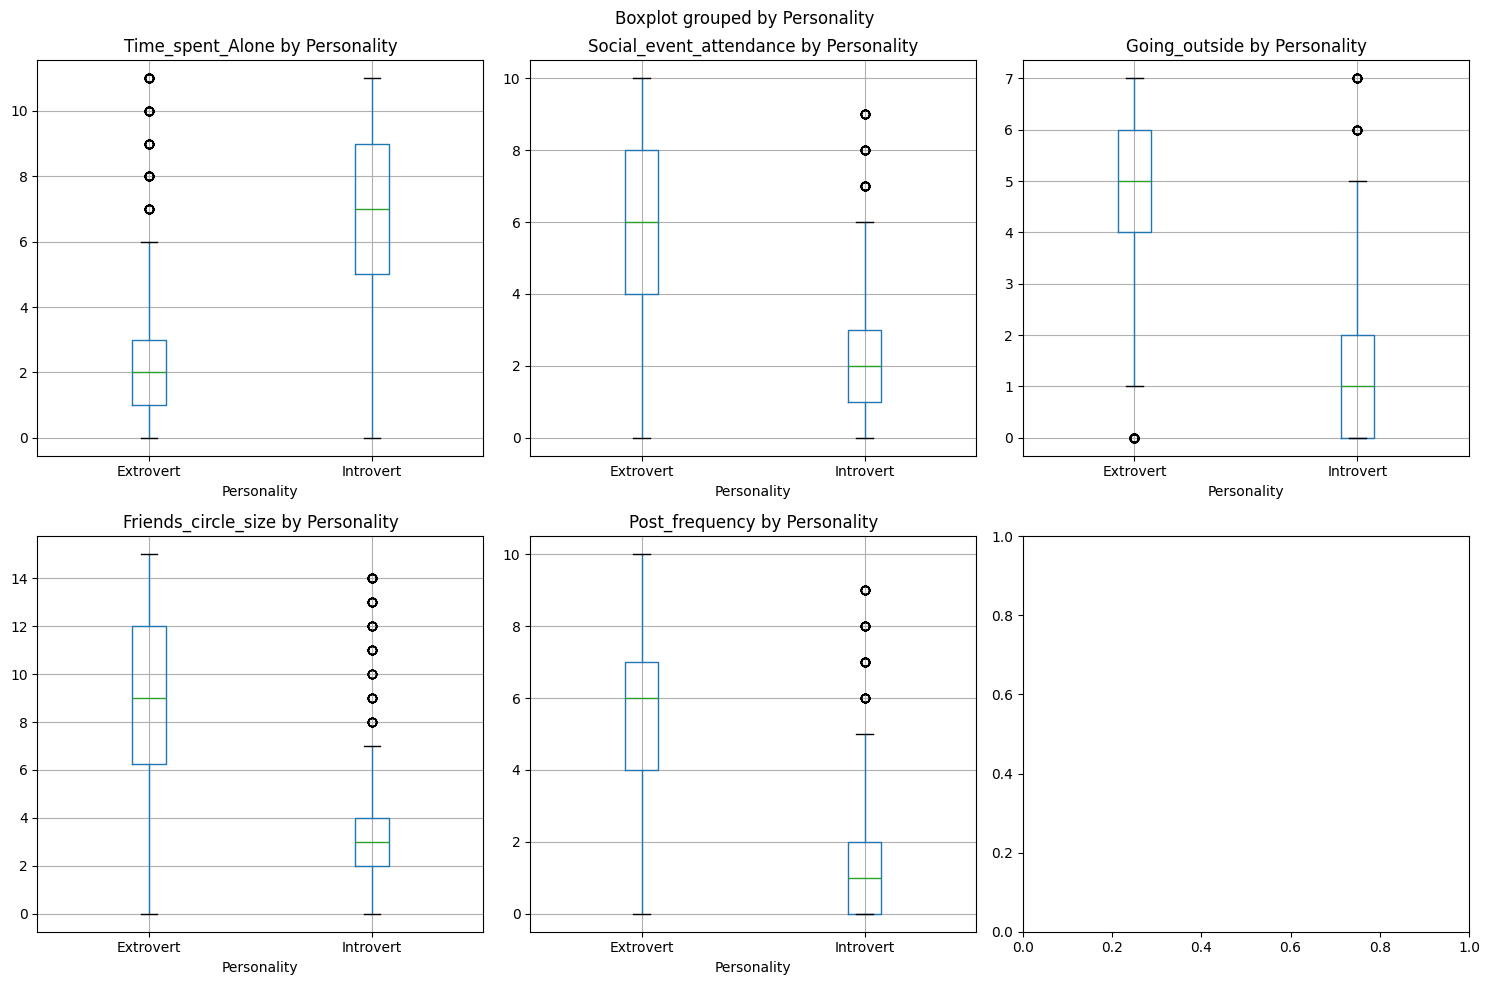

VIF Results:
                    Feature       VIF Multicollinearity
0         Time_spent_Alone  1.225581               Low
1  Social_event_attendance  8.068336          Moderate
2            Going_outside  8.465878          Moderate
3      Friends_circle_size  7.804731          Moderate
4           Post_frequency  7.248266          Moderate


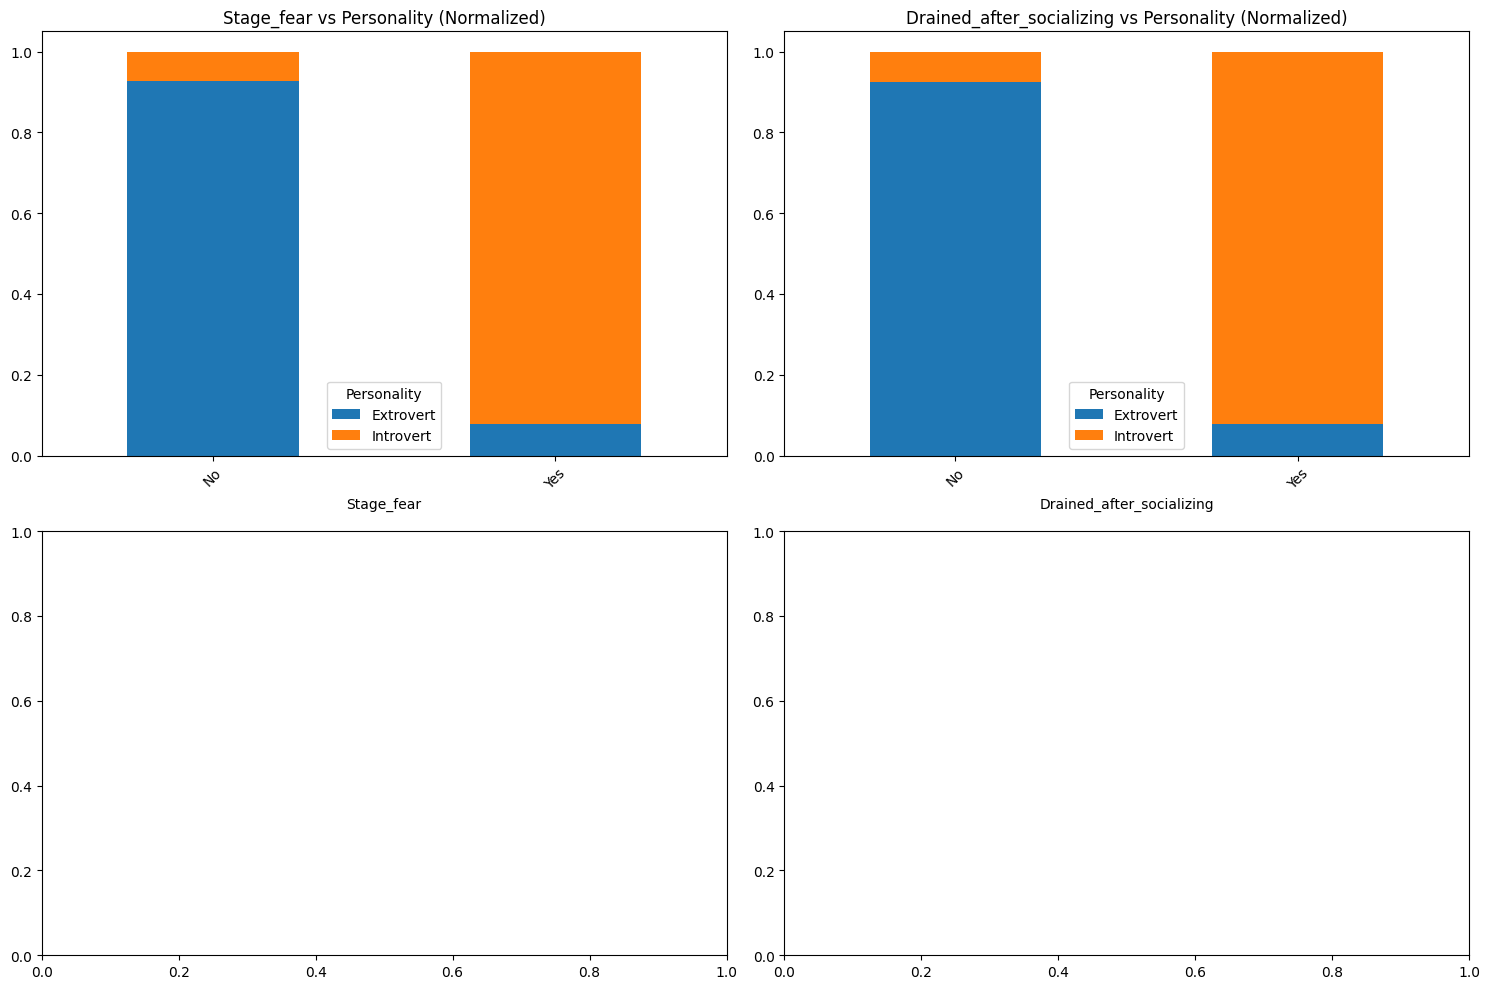

All EDA Results: {'basic_info': {'shape': (2900, 8), 'columns': ['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance', 'Going_outside', 'Drained_after_socializing', 'Friends_circle_size', 'Post_frequency', 'Personality'], 'dtypes': {'Time_spent_Alone': dtype('float64'), 'Stage_fear': dtype('O'), 'Social_event_attendance': dtype('float64'), 'Going_outside': dtype('float64'), 'Drained_after_socializing': dtype('O'), 'Friends_circle_size': dtype('float64'), 'Post_frequency': dtype('float64'), 'Personality': dtype('O')}, 'missing_values': {'Time_spent_Alone': 0, 'Stage_fear': 0, 'Social_event_attendance': 0, 'Going_outside': 0, 'Drained_after_socializing': 0, 'Friends_circle_size': 0, 'Post_frequency': 0, 'Personality': 0}, 'duplicates': np.int64(402), 'target_distribution': {'Extrovert': 1491, 'Introvert': 1409}, 'class_balance': {'Extrovert': 0.5141379310344828, 'Introvert': 0.48586206896551726}}, 'correlation_matrix': {'Time_spent_Alone': {'Time_spent_Alone': 1.0, 'Social_event_a

In [21]:
# Instantiate the EDA Analyzer (replace 'your_dataframe' and 'your_target_column')
# For example, if your dataframe is called 'df' and the target is 'churn':
eda_analyzer = ClassificationEDAAnalyzer(df, 'Personality')

# Run the basic information analysis
basic_info_results = eda_analyzer.basic_info()
print("Basic Info:", basic_info_results)

# Visualize target distribution
eda_analyzer.target_distribution_plot()

# Perform correlation analysis
correlation_matrix = eda_analyzer.correlation_analysis()
print("Correlation Matrix:", correlation_matrix)

# Analyze relationship between features and target
eda_analyzer.feature_target_analysis()

# Perform VIF analysis (requires at least 2 numeric features)
vif_results = eda_analyzer.vif_analysis()
if vif_results is not None:
  print("VIF Results:\n", vif_results)

# Analyze categorical features (requires categorical features other than target)
eda_analyzer.categorical_analysis()

# Access all results stored in the instance
print("All EDA Results:", eda_analyzer.eda_results)


 # Classification Model Training with Hyperparameter Tuning

In [35]:
class ClassificationModelTrainer:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.models = {}
        self.best_model = None
        self.best_params = None
        self.results = {}
        self.label_encoder = None

    def prepare_data(self):
        """Split and scale data"""
        # Encode target if it's categorical
        if self.y.dtype == 'object':
            self.label_encoder = LabelEncoder()
            y_encoded = self.label_encoder.fit_transform(self.y)
        else:
            y_encoded = self.y

        X_train, X_test, y_train, y_test = train_test_split(
            self.X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )

        # Scale the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        return X_train_scaled, X_test_scaled, y_train, y_test, scaler

    def train_models(self):
        """Train multiple classification models with hyperparameter tuning"""
        X_train, X_test, y_train, y_test, scaler = self.prepare_data()

        # Define models and their hyperparameters
        model_configs = {
            'RandomForest': {
                'model': RandomForestClassifier(random_state=42),
                'params': {
                    'n_estimators': [100, 200],
                    'max_depth': [10, 20, None],
                    'min_samples_split': [2, 5],
                    'min_samples_leaf': [1, 2]
                }
            },
            'GradientBoosting': {
                'model': GradientBoostingClassifier(random_state=42),
                'params': {
                    'n_estimators': [100, 200],
                    'learning_rate': [0.01, 0.1, 0.2],
                    'max_depth': [3, 5, 7]
                }
            },
            'LogisticRegression': {
                'model': LogisticRegression(random_state=42, max_iter=1000),
                'params': {
                    'C': [0.1, 1.0, 10.0],
                    'penalty': ['l1', 'l2'],
                    'solver': ['liblinear']
                }
            },
            'SVM': {
                'model': SVC(random_state=42, probability=True),
                'params': {
                    'C': [0.1, 1, 10],
                    'kernel': ['rbf', 'linear'],
                    'gamma': ['scale', 'auto']
                }
            }
        }

        best_score = 0

        for name, config in model_configs.items():
            print(f"Training {name}...")

            # Grid search for hyperparameter tuning
            grid_search = GridSearchCV(
                config['model'],
                config['params'],
                cv=5,
                scoring='f1_weighted',  # Use weighted F1 for imbalanced datasets
                n_jobs=-1
            )

            grid_search.fit(X_train, y_train)

            # Make predictions
            y_pred = grid_search.predict(X_test)
            y_pred_proba = grid_search.predict_proba(X_test)

            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')

            # ROC AUC for binary classification
            if len(np.unique(y_test)) == 2:
                roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
            else:
                roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')

            # Store results
            self.results[name] = {
                'best_params': grid_search.best_params_,
                'best_score': grid_search.best_score_,
                'test_accuracy': accuracy,
                'test_precision': precision,
                'test_recall': recall,
                'test_f1': f1,
                'test_roc_auc': roc_auc,
                'confusion_matrix': confusion_matrix(y_test, y_pred).tolist(),
                'classification_report': classification_report(y_test, y_pred, output_dict=True)
            }

            # Update best model based on F1 score
            if f1 > best_score:
                best_score = f1
                self.best_model = grid_search.best_estimator_
                self.best_params = grid_search.best_params_
                self.best_model_name = name

        return self.results, scaler

    def plot_confusion_matrices(self):
        """Plot confusion matrices for all models"""
        n_models = len(self.results)
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        axes = axes.ravel()

        for i, (name, results) in enumerate(self.results.items()):
            if i < 4:
                cm = np.array(results['confusion_matrix'])
                sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues')
                axes[i].set_title(f'{name} - Confusion Matrix')
                axes[i].set_xlabel('Predicted')
                axes[i].set_ylabel('Actual')

        plt.tight_layout()
        plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
        plt.show()

    def plot_roc_curves(self, X_test, y_test):
        """Plot ROC curves for binary classification"""
        if len(np.unique(y_test)) != 2:
            print("ROC curves only available for binary classification")
            return

        plt.figure(figsize=(10, 8))

        for name, model_result in self.results.items():
            # Get model and make predictions
            model = self.models.get(name)
            if model:
                y_pred_proba = model.predict_proba(X_test)[:, 1]
                fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
                auc_score = roc_auc_score(y_test, y_pred_proba)

                plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

        plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves Comparison')
        plt.legend()
        plt.grid(True)
        plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
        plt.show()

    def save_model(self, scaler):
        """Save the best classification model and preprocessing objects"""
        model_data = {
            'model': self.best_model,
            'scaler': scaler,
            'label_encoder': self.label_encoder,
            'model_name': self.best_model_name,
            'best_params': self.best_params,
            'results': self.results,
            'feature_names': list(self.X.columns),
            'classes': self.label_encoder.classes_.tolist() if self.label_encoder else None
        }

        with open('classification_model.pickle', 'wb') as f:
            pickle.dump(model_data, f)

        print(f"Best classification model ({self.best_model_name}) saved successfully!")
        print(f"Best F1 Score: {max([r['test_f1'] for r in self.results.values()]):.4f}")
        return model_data


In [38]:
# prompt: next step to foolow

import numpy as np
# Instantiate the Model Trainer
# Assuming 'X' is your feature dataframe and 'y' is your target series/array
model_trainer = ClassificationModelTrainer(x, y)
results, scaler = model_trainer.train_models()


Training RandomForest...
Training GradientBoosting...
Training LogisticRegression...
Training SVM...


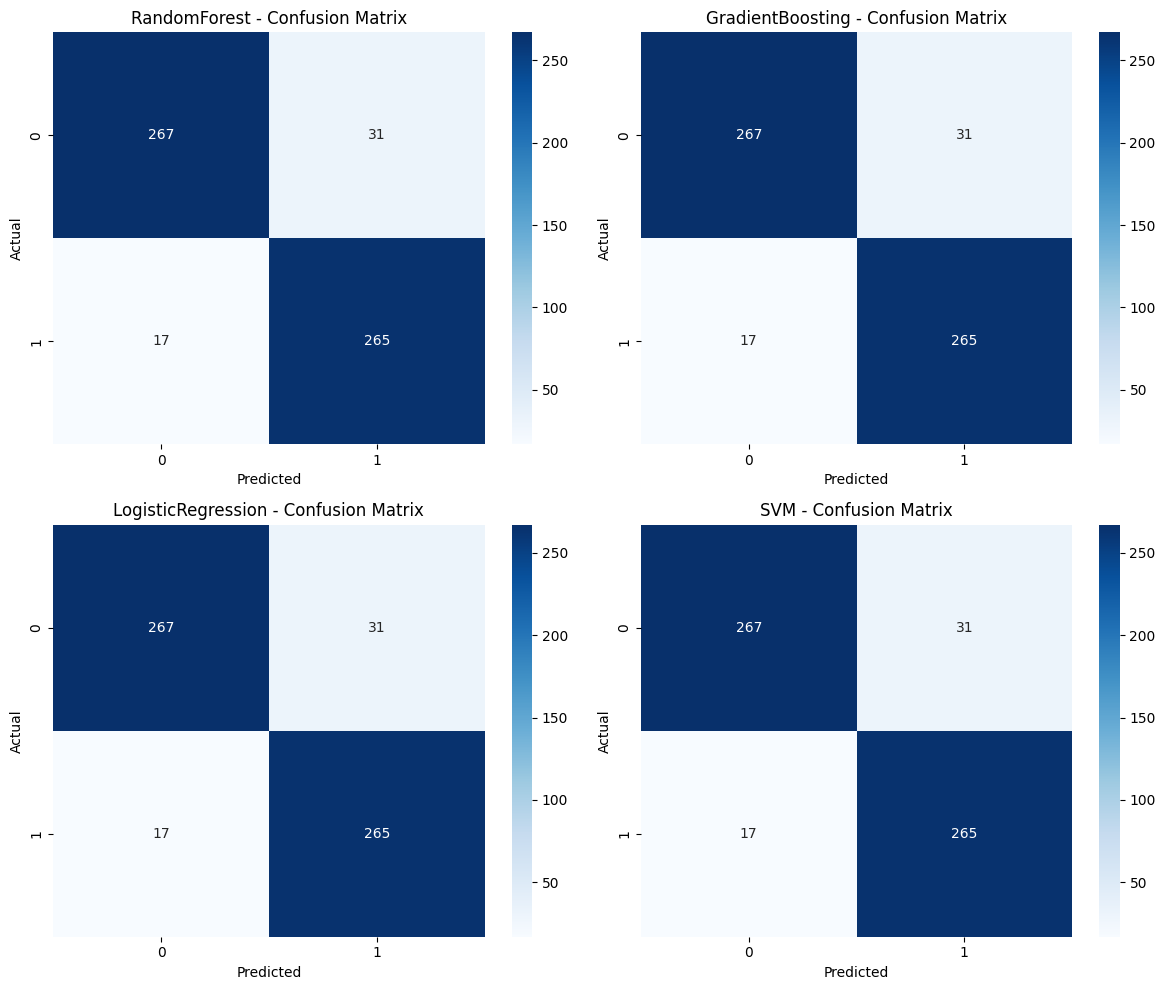

In [40]:
model_trainer.plot_confusion_matrices()


In [42]:
model_data = model_trainer.save_model(scaler)


Best classification model (RandomForest) saved successfully!
Best F1 Score: 0.9172
